In [ ]:
import random

# Randomize positions
def randomize_grid(seed=None, num_dogs=4, num_mice=2, num_catnip=1):
    global DOGS, MICE, CATNIP

    if seed is not None:
        random.seed(seed)

    all_positions = [(x, y) for x in range(5) for y in range(5)]
    random.shuffle(all_positions)

    DOGS = all_positions[:num_dogs]
    MICE = all_positions[num_dogs:num_dogs + num_mice]
    CATNIP = all_positions[num_dogs + num_mice:num_dogs + num_mice + num_catnip]

    print(f"DOGS at: {DOGS}")
    print(f"MICE at: {MICE}")
    print(f"CATNIP at: {CATNIP}")

In [ ]:
# %matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from IPython.display import clear_output, display
import time

# Gridworld setup
GRID_SIZE = 5
ACTIONS = ['UP', 'DOWN', 'LEFT', 'RIGHT']
ACTION_TO_DELTA = {
    'UP': (-1, 0),
    'DOWN': (1, 0),
    'LEFT': (0, -1),
    'RIGHT': (0, 1),
}
GAMMA = 0.9
THETA = 0.001

#DOGS = [(1, 1), (3, 3)]
#MICE = [(0, 4), (4, 0)]
#CATNIP = [(2, 2)]
randomize_grid(seed=5, num_dogs=5, num_mice=3, num_catnip=1)
health_bins = list(range(0, 120, 20))

def get_reward(pos, caught_mice):
    if pos in DOGS:
        return -50
    elif pos in CATNIP:
        return 30
    elif pos in MICE and pos not in caught_mice:
        return 100
    return -1

def update_health(health, pos):
    if pos in DOGS:
        return max(0, health - 50)
    elif pos in CATNIP:
        return min(100, health + 30)
    return health

def is_terminal(pos, health, caught_mice):
    return health <= 0 or (set(caught_mice) == set(MICE) and health > 50)

def in_bounds(x, y):
    return 0 <= x < GRID_SIZE and 0 <= y < GRID_SIZE

def create_state_space():
    return [(x, y, h) for x in range(GRID_SIZE) for y in range(GRID_SIZE) for h in health_bins]

def visualize_policy_grid(policy, V, caught_mice, iteration):
    fig, ax = plt.subplots(figsize=(3, 3))
    ax.set_xlim(0, GRID_SIZE)
    ax.set_ylim(0, GRID_SIZE)
    ax.set_xticks(np.arange(0, GRID_SIZE + 1))
    ax.set_yticks(np.arange(0, GRID_SIZE + 1))
    ax.grid(True)
    ax.set_title(f"Policy Iteration - Iteration {iteration}")

    arrow_map = {
        'UP': (0, 0.3, '^'),
        'DOWN': (0, -0.3, 'v'),
        'LEFT': (-0.3, 0, '<'),
        'RIGHT': (0.3, 0, '>'),
    }

    for x in range(GRID_SIZE):
        for y in range(GRID_SIZE):
            best_action = policy.get((x, y, 100), None)
            if best_action:
                dx, dy, arrow = arrow_map[best_action]
                ax.text(y + 0.5 + dx, GRID_SIZE - x - 0.5 + dy, arrow, fontsize=16, ha='center', va='center')

            pos = (x, y)
            if pos in DOGS:
                ax.add_patch(patches.Rectangle((y, GRID_SIZE - x - 1), 1, 1, color='red', alpha=0.3))
                ax.text(y + 0.5, GRID_SIZE - x - 0.5, 'DOG', ha='center', va='center', fontsize=6)
            elif pos in MICE and pos not in caught_mice:
                ax.add_patch(patches.Rectangle((y, GRID_SIZE - x - 1), 1, 1, color='green', alpha=0.3))
                ax.text(y + 0.5, GRID_SIZE - x - 0.5, 'MOUSE', ha='center', va='center', fontsize=6)
            elif pos in CATNIP:
                ax.add_patch(patches.Rectangle((y, GRID_SIZE - x - 1), 1, 1, color='blue', alpha=0.3))
                ax.text(y + 0.5, GRID_SIZE - x - 0.5, 'CATNIP', ha='center', va='center', fontsize=6)

    display(fig)
    plt.close(fig)
    #time.sleep(0.3)

def policy_iteration(caught_mice):
    states = create_state_space()
    policy = {s: np.random.choice(ACTIONS) for s in states}
    V = {s: 0 for s in states}
    iteration = 0

    while True:
        # Policy Evaluation
        while True:
            delta = 0
            for state in states:
                x, y, h = state
                if h <= 0:
                    continue
                a = policy[state]
                dx, dy = ACTION_TO_DELTA[a]
                nx, ny = x + dx, y + dy
                if not in_bounds(nx, ny):
                    nx, ny = x, y
                pos = (nx, ny)
                reward = get_reward(pos, caught_mice)
                new_health = update_health(h, pos)
                new_health_bin = max(0, min(100, new_health))
                new_health_bin -= new_health_bin % 20
                next_state = (nx, ny, new_health_bin)
                v = reward + GAMMA * V.get(next_state, 0)
                delta = max(delta, abs(V[state] - v))
                V[state] = v
            if delta < THETA:
                break

        clear_output(wait=True)
        print(f"\n--- Policy Improvement Iteration {iteration} ---")

        # Debug printout
        for state in sorted(states)[:-10]:  # show sample of last 10 states
            x, y, h = state
            action = policy[state]
            v_val = round(V[state], 2)
            print(f"State: (X: {x}, Y: {y}, Health: {h}) | Action: {action} | State Value: {v_val}")

        visualize_policy_grid(policy, V, caught_mice, iteration)

        # Policy Improvement
        stable = True
        for state in states:
            x, y, h = state
            if h <= 0:
                continue
            old_action = policy[state]
            action_values = {}
            for a in ACTIONS:
                dx, dy = ACTION_TO_DELTA[a]
                nx, ny = x + dx, y + dy
                if not in_bounds(nx, ny):
                    nx, ny = x, y
                pos = (nx, ny)
                reward = get_reward(pos, caught_mice)
                new_health = update_health(h, pos)
                new_health_bin = max(0, min(100, new_health))
                new_health_bin -= new_health_bin % 20
                next_state = (nx, ny, new_health_bin)
                action_values[a] = reward + GAMMA * V.get(next_state, 0)
            best_action = max(action_values, key=action_values.get)
            policy[state] = best_action
            if best_action != old_action:
                stable = False

        iteration += 1
        if stable:
            break

    return policy

def simulate_dynamic(start=(0, 0, 40)):
    x, y, h = start
    path = [(x, y, h)]
    caught_mice = []
    stuck_counter = 0

    print(f"Position: ({x}, {y}) | Health: {h}")
    for step in range(50):
        print(f"\n-- Step {step} --")
        policy = policy_iteration(caught_mice)
        state_key = (x, y, h - h % 20)
        action = policy.get(state_key, 'RIGHT')
        dx, dy = ACTION_TO_DELTA[action]
        nx, ny = x + dx, y + dy
        if not in_bounds(nx, ny):
            nx, ny = x, y
        pos = (nx, ny)

        if pos in MICE and pos not in caught_mice:
            caught_mice.append(pos)
            print(f"Caught mouse at: {pos}")

        new_health = update_health(h, pos if pos not in caught_mice else (-1, -1))
        path.append((nx, ny, new_health))

        print(f"Cat moved to: ({nx}, {ny}) | Action: {action}")

        if is_terminal(pos, new_health, caught_mice):
            print(f"\nEpisode ended at step {step}")
            print(f"Final Pos: ({nx}, {ny}) | Health: {new_health} | Mice Caught: {len(caught_mice)}")
            break

        if (nx, ny) == (x, y):
            stuck_counter += 1
        else:
            stuck_counter = 0
        if stuck_counter >= 5:
            print("Terminating early due to stuck behavior.")
            break

        x, y, h = nx, ny, new_health

    return path, caught_mice

def draw_grid(path, caught_mice_log):
    tile_emojis = {
        "cat": "🐱",
        "dog": "🐶",
        "mouse": "🐭",
        "caught": "🕳️",
        "catnip": "🌿",
        "empty": "⬜",
    }
    caught_mice = set()

    for step, (x, y, h) in enumerate(path):
        grid_display = [[tile_emojis["empty"] for _ in range(GRID_SIZE)] for _ in range(GRID_SIZE)]

        for dx, dy in DOGS:
            grid_display[dx][dy] = tile_emojis["dog"]
        for mx, my in MICE:
            if (mx, my) in caught_mice:
                grid_display[mx][my] = tile_emojis["caught"]
            else:
                grid_display[mx][my] = tile_emojis["mouse"]
        for cx, cy in CATNIP:
            grid_display[cx][cy] = tile_emojis["catnip"]

        grid_display[x][y] = tile_emojis["cat"]
        if (x, y) in MICE:
            caught_mice.add((x, y))

        #clear_output(wait=True)
        print(f"Step {step} | Cat at ({x},{y}) | Health: {h}")
        print("Legend: 🐱 Cat | 🐭 Mouse | 🕳️ Caught | 🐶 Dog | 🌿 Catnip | ⬜ Empty")
        print("=" * (GRID_SIZE * 2 + 2))
        for row in grid_display:
            print(" ".join(row))
        print("=" * (GRID_SIZE * 2 + 2))
        time.sleep(0.8)

    print('Finished!')

DOGS at: [(0, 2), (2, 0), (0, 4), (2, 2), (1, 4)]
MICE at: [(2, 3), (4, 4), (4, 2)]
CATNIP at: [(3, 3)]



--- Policy Improvement Iteration 5 ---
State: (X: 0, Y: 0, Health: 0) | Action: LEFT | State Value: 0
State: (X: 0, Y: 0, Health: 20) | Action: DOWN | State Value: 435.11
State: (X: 0, Y: 0, Health: 40) | Action: DOWN | State Value: 435.11
State: (X: 0, Y: 0, Health: 60) | Action: DOWN | State Value: 435.11
State: (X: 0, Y: 0, Health: 80) | Action: DOWN | State Value: 435.11
State: (X: 0, Y: 0, Health: 100) | Action: DOWN | State Value: 435.11
State: (X: 0, Y: 1, Health: 0) | Action: DOWN | State Value: 0
State: (X: 0, Y: 1, Health: 20) | Action: DOWN | State Value: 484.57
State: (X: 0, Y: 1, Health: 40) | Action: DOWN | State Value: 484.57
State: (X: 0, Y: 1, Health: 60) | Action: DOWN | State Value: 484.57
State: (X: 0, Y: 1, Health: 80) | Action: DOWN | State Value: 484.57
State: (X: 0, Y: 1, Health: 100) | Action: DOWN | State Value: 484.57
State: (X: 0, Y: 2, Health: 0) | Action: LEFT | State Value: 0
State: (X: 0, Y: 2, Health: 20) | Action: DOWN | State Value: 539.52
State: (X:

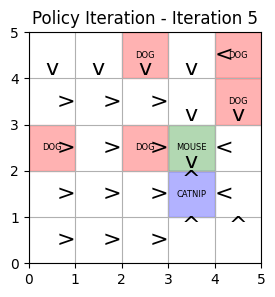

Caught mouse at: (2, 3)
Cat moved to: (2, 3) | Action: UP

Episode ended at step 10
Final Pos: (2, 3) | Health: 70 | Mice Caught: 3


In [ ]:
path, caught_mice = simulate_dynamic()

In [ ]:
draw_grid(path, caught_mice)

Step 0 | Cat at (0,0) | Health: 40
Legend: 🐱 Cat | 🐭 Mouse | 🕳️ Caught | 🐶 Dog | 🌿 Catnip | ⬜ Empty
🐱 ⬜ 🐶 ⬜ 🐶
⬜ ⬜ ⬜ ⬜ 🐶
🐶 ⬜ 🐶 🐭 ⬜
⬜ ⬜ ⬜ 🌿 ⬜
⬜ ⬜ 🐭 ⬜ 🐭
Step 1 | Cat at (1,0) | Health: 40
Legend: 🐱 Cat | 🐭 Mouse | 🕳️ Caught | 🐶 Dog | 🌿 Catnip | ⬜ Empty
⬜ ⬜ 🐶 ⬜ 🐶
🐱 ⬜ ⬜ ⬜ 🐶
🐶 ⬜ 🐶 🐭 ⬜
⬜ ⬜ ⬜ 🌿 ⬜
⬜ ⬜ 🐭 ⬜ 🐭
Step 2 | Cat at (1,1) | Health: 40
Legend: 🐱 Cat | 🐭 Mouse | 🕳️ Caught | 🐶 Dog | 🌿 Catnip | ⬜ Empty
⬜ ⬜ 🐶 ⬜ 🐶
⬜ 🐱 ⬜ ⬜ 🐶
🐶 ⬜ 🐶 🐭 ⬜
⬜ ⬜ ⬜ 🌿 ⬜
⬜ ⬜ 🐭 ⬜ 🐭
Step 3 | Cat at (2,1) | Health: 40
Legend: 🐱 Cat | 🐭 Mouse | 🕳️ Caught | 🐶 Dog | 🌿 Catnip | ⬜ Empty
⬜ ⬜ 🐶 ⬜ 🐶
⬜ ⬜ ⬜ ⬜ 🐶
🐶 🐱 🐶 🐭 ⬜
⬜ ⬜ ⬜ 🌿 ⬜
⬜ ⬜ 🐭 ⬜ 🐭
Step 4 | Cat at (3,1) | Health: 40
Legend: 🐱 Cat | 🐭 Mouse | 🕳️ Caught | 🐶 Dog | 🌿 Catnip | ⬜ Empty
⬜ ⬜ 🐶 ⬜ 🐶
⬜ ⬜ ⬜ ⬜ 🐶
🐶 ⬜ 🐶 🐭 ⬜
⬜ 🐱 ⬜ 🌿 ⬜
⬜ ⬜ 🐭 ⬜ 🐭
Step 5 | Cat at (4,1) | Health: 40
Legend: 🐱 Cat | 🐭 Mouse | 🕳️ Caught | 🐶 Dog | 🌿 Catnip | ⬜ Empty
⬜ ⬜ 🐶 ⬜ 🐶
⬜ ⬜ ⬜ ⬜ 🐶
🐶 ⬜ 🐶 🐭 ⬜
⬜ ⬜ ⬜ 🌿 ⬜
⬜ 🐱 🐭 ⬜ 🐭
Step 6 | Cat at (4,2) | Health: 40
Legend: 🐱 Cat | 🐭 Mouse | 🕳️ Caught | 🐶 Dog | 🌿 Catnip | ⬜ Empty
